In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
import sklearn

In [2]:
### uncomment the line below to get figures in pop-up windows, that you can then drag and turn around 
### (nice to see 3D plots correctly)
# %matplotlib qt  
### disable the line above if you have errors, or if you prefer figures to remain 
### embedded in the notebook (no pop-ups)

In [3]:
def plot_data(X, y):
    plt.figure(figsize=[5,5]) ## equal x and y lengths for a squared figure
    plt.scatter(X[:, 0], X[:, 1], c=y, s = 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    #plt.legend()

In [4]:
import TP3_helper_function_dont_look
X, yregress, yclassif = TP3_helper_function_dont_look.getData(42)
X_test, yregress_test, yclassif_test = TP3_helper_function_dont_look.getData(41, 1000)

### Note:

In this TP, we sometimes use a very large amount of test data, so as to get a "true value" (not really "true", but quite converged) for the test error. This is useful pedagogically, to understand how $N_{train}$ or hyper-parameters can impact the quality of the model that is learned. 

In real life, of course, you generally use more data for training than for testing, since it's better to improve the results (increase $N_{train}$) than to improve the accuracy of measurement of the (test) error (increase $N_{test}$).

# Part 1: classification of the XOR data set

You're going to code your own feature map, so as to classify the XOR dataset.

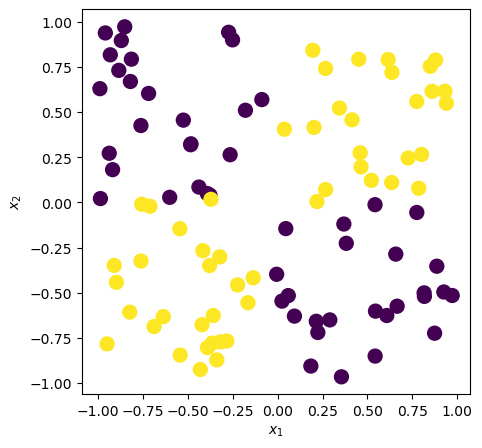

In [5]:
plot_data(X, yclassif)

In [6]:
## the default feature map is the identity function
def defaultFeatureMap(X):
    return X

In [25]:
## a function to plot the domains of prediction (for a classification)
## the idea is to grid the (2D) pre-feature-map space with a mesh, and 
## display the predicted class with a color, in each little square of the mesh.
def plot_boundary(clf, X, y, featureMap=None):
    if featureMap == None:
        featureMap = defaultFeatureMap
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1 
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    hx = hy = 0.002 ## grid mesh size
    hx = (x_max-x_min)/200 ## grid mesh size
    hy = (y_max-y_min)/200 ## grid mesh size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))
    Z = clf.predict(featureMap(np.c_[xx.ravel(), yy.ravel()])) ## prediction value by zone
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=[4,4]) ## equal x and y lengths for a squared figure
    plt.title('score : ' + str(clf.score(featureMap(X),y)))    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s = 10)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()

## Reminder: full-batch Perceptron (linear classifier)

Or actually, we may simply call it linear classifier.

## Question 1.1 : Complete the class that is provided below

Then run it on your data, `X`, `yclassif`

### About python classes

- members of the class are accessed with the syntax `self.myMemberObject` (regardless of its nature, function, variable, sub-class, etc).
- functions (methods) of the class always take the argument `self` as first argument. Look at the example of the two lines of code, `def initializeWeights(self,D):` and  `w = self.initializeWeights(D)`. You see that `self` does not need to be passed as an argument because it's already present when we do `self.MyFunction`
- the `__init__` function initializes (instanciates) an instance of the class with some parameters (default values or passed as arguments of the constructor when a instance is created)


You can also check out what is expected from a typical sklearn class by looking at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression or  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron

In [12]:
class classLinearClassifierFullBatch():

    def __init__(self, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        self.eta = eta
        self.maxIter = maxIter
        self.seed = seed
        self.w = None # at the start, it's undefined
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((D))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y):
        ## the full-batch perceptron in its cleanest form
#         assert(set(y)={-1,1}) ## try TODO this 
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) # extended vector, with 1's as first component
        D = X.shape[1]        
        w0 = self.initializeWeights(D)       
        wparameters = w0.copy()  # deep copy
        assert(y.shape[0]==N)
        for epoch in range(self.maxIter):
            misClassified = ((X @ wparameters)*y  <= 0) ## array of booleans (used as a mask or filter)
            wparameters -= -self.eta/N * (y[misClassified]@X[misClassified])
            ## tracking progress of the algo:
            Nerrors = misClassified.sum()
            Loss = ((X @ wparameters)*y)[misClassified].sum()
            if epoch % (self.maxIter//10) ==0 and self.verbose :
                print("epoch ",epoch ,"out of ",self.maxIter,", Loss:", Loss)      
        self.w = wparameters
        return wparameters
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) 
        ypredicted = np.sign(np.dot(X,self.w))
        return ypredicted
    
    def score(self, X, y):
        ypred = self.predict(X)
        difference = (ypred-y)
        countingTheNumberOfDifferentSamples = (np.abs(difference)>0).sum()
        rateOfCorrectClassif = 1 - countingTheNumberOfDifferentSamples*1.0/X.shape[0]
        rateOfCorrectClassif = (ypred == y).mean()
        return rateOfCorrectClassif

In [13]:
# note that the order of the parameters does not matter (since they have keywords)
clf = classLinearClassifierFullBatch(eta=0.01, seed=41, maxIter=3000) 
clf.fit(X,yclassif)

epoch  0 out of  3000 , Loss: -9.691694007136007
epoch  300 out of  3000 , Loss: 0.10528112338154297
epoch  600 out of  3000 , Loss: 0.125581741523594
epoch  900 out of  3000 , Loss: 0.0735572160327916
epoch  1200 out of  3000 , Loss: 0.13441135875270885
epoch  1500 out of  3000 , Loss: 0.1100430727934961
epoch  1800 out of  3000 , Loss: 0.07867197176102848
epoch  2100 out of  3000 , Loss: 0.07835440718993575
epoch  2400 out of  3000 , Loss: 0.1386643059920549
epoch  2700 out of  3000 , Loss: 0.11471815728630644


array([ 0.00219569,  0.00221491, -0.00050596])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


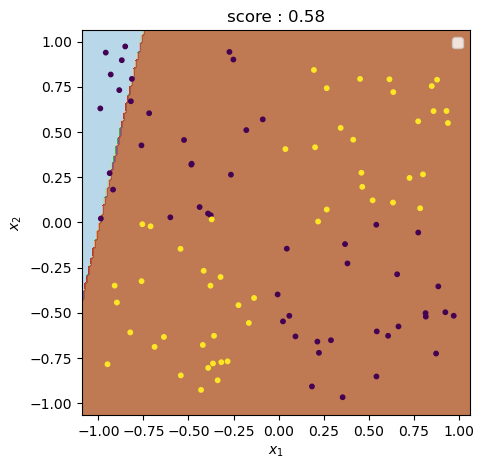

In [14]:
plot_boundary(clf, X, yclassif)

## Question 1.2 : 

Are you happy with this classification ?

What can be done to improve it ?

## Answer: 

it's very bad ! There is no way we can classify the XOR data set with a linear classifier.. except if.. we use feature maps ?

In [19]:
def featureMap(X):
    return np.array([X[:,0],X[:,1], X[:,0]**2, X[:,0]*X[:,1],  X[:,1]**2 ]).T

## Question 1.3 : make your own feature map ! 

- Define a feature map. For instance, you may use a polynomial feature map. Go back to the lecture notes if you are out of ideas. Simpler is better ! (at least for today)
- create a new vector $X_f = \phi(X)$, i.e. the transform of your dataset through this feature-map
- use it as input in our LINEAR classification model
- look at the score and plot the result using plot_boundary()

Advice: create a new instance of your classifier class, so as to not confuse 
- the fitted model which expects the raw data and 
- the fitted model which expects the augmented (featurized) data

If we did things right, we do not need to change our model (the whole python class) AT ALL.

In [21]:
def featureMap(X):
    return np.array([X[:,0]**2, X[:,0]*X[:,1], X[:,1]**2,  X[:,0], X[:,1], ]).T 

### Remark: check carefully that your data after applying the feature map has the reasonable shape. If not, transpose it, or do something with your function

In [22]:
featureMap(X).shape

(100, 5)

In [23]:
clf2 = classLinearClassifierFullBatch(eta=0.003, seed=41, maxIter=30000) # order of parameters does not matter
Xf = featureMap(X)
clf2.fit(Xf,yclassif)
clf2.score(Xf,yclassif)

epoch  0 out of  30000 , Loss: -10.264049659602954
epoch  3000 out of  30000 , Loss: -0.0010580545776338757
epoch  6000 out of  30000 , Loss: 0.0
epoch  9000 out of  30000 , Loss: 0.0
epoch  12000 out of  30000 , Loss: 0.0
epoch  15000 out of  30000 , Loss: 0.0
epoch  18000 out of  30000 , Loss: 0.0
epoch  21000 out of  30000 , Loss: 0.0
epoch  24000 out of  30000 , Loss: 0.0
epoch  27000 out of  30000 , Loss: 0.0


1.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


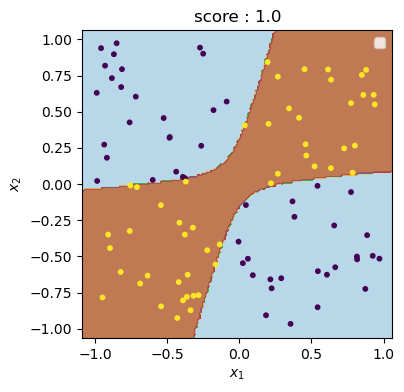

In [26]:
plot_boundary(clf2, X, yclassif, featureMap)

## Question 1.4 : are you happy with this classification ?


## Answer: 

# Yes ! 

It's much much better than before

## Question 1.5: compute the test error/score,and display the results for the test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


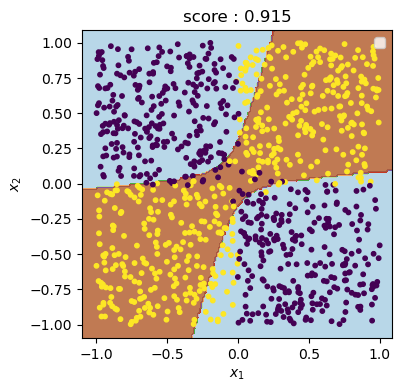

In [27]:
plot_boundary(clf2, X_test, yclassif_test, featureMap)

## Question 1.6:

build the *learning curve* of the problem.

You may choose an exponentially growing number of training examples, such as `Ntrains = [10,30,100,300,1000, 3000, 10000]`, and a large number of test examples, for the sake of having a precise estimation of the test error. You should probably use log-log or semilog- plots.
    

In [30]:

clf2 = classLinearClassifierFullBatch(eta=0.01, seed=41, maxIter=30000, verbose=False) # order of parameters does not matter
score_train =[]
score_test  =[]
Ntrains = [10,30,100,300,1000, 3000, 10000]
Ntrain = 200
X_test, yregress_test, yclassif_test = TP3_helper_function_dont_look.getData(41, 10000)
X_total, yregress_total, yclassif_total = TP3_helper_function_dont_look.getData(43, 10000)
Xf_test = featureMap(X_test)
for Ntrain in Ntrains:
#     X, yregress, yclassif = TP3_helper_function_dont_look.getData(42, Ntrain) ## weird way of doing it..
    X, yregress, yclassif = X_total[:Ntrain], yregress_total[:Ntrain], yclassif_total[:Ntrain]
    Xf = featureMap(X)
    clf2.fit(Xf,yclassif)
    score_train.append(clf2.score(Xf,yclassif))
    score_test .append(clf2.score(Xf_test,yclassif_test))
score_train = np.array(score_train)
score_test = np.array(score_test)


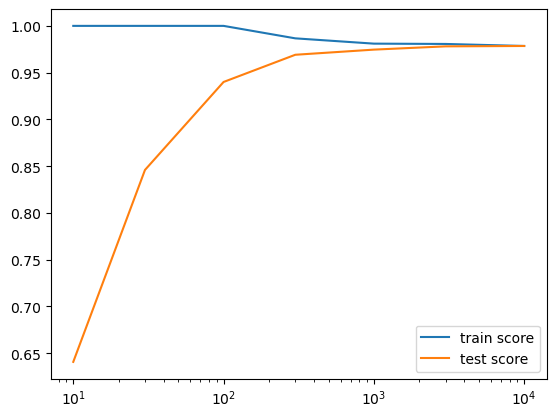

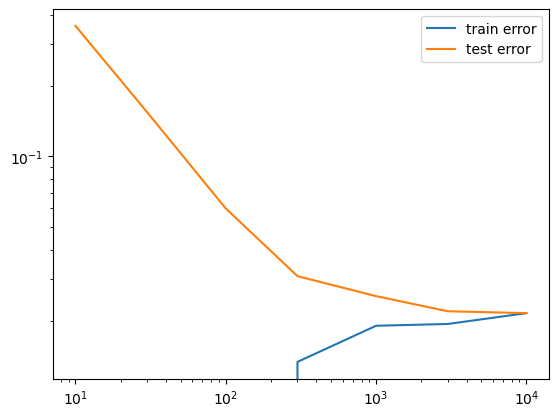

In [31]:
plt.semilogx(Ntrains, score_train, label="train score")
plt.plot(Ntrains, score_test, label="test score")
plt.legend()
plt.figure()
plt.loglog(Ntrains, 1-score_train, label="train error")
plt.plot(Ntrains, 1-score_test, label="test error")
plt.legend()

No handles with labels found to put in legend.


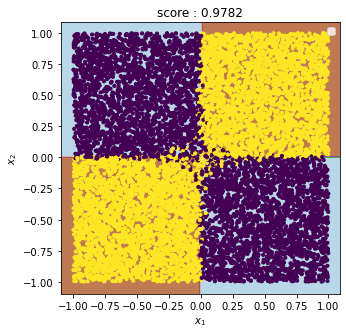

In [18]:
plot_boundary(clf2, X_test, yclassif_test, featureMap)

# Part 2: same thing but with regression !

Now we re-do the same thing but for a regression task.
The data is `X, yregress`

In [19]:
X, yregress, yclassif = TP3_helper_function_dont_look.getData(42)
X_test, yregress_test, yclassif_test = TP3_helper_function_dont_look.getData(41, 1000)

In [20]:
X[:5,:], yregress[:5]

(array([[-0.25091976,  0.90142861],
        [ 0.46398788,  0.19731697],
        [-0.68796272, -0.68801096],
        [-0.88383278,  0.73235229],
        [ 0.20223002,  0.41614516]]),
 array([-0.2329865 ,  0.09387522,  0.47625662, -0.65442047,  0.10281479]))

In [21]:
def twod_scatter_plot_colored_value(X, y):
    plt.scatter(X[:,0], X[:,1], s=10, c=y, cmap='jet')
    plt.colorbar()

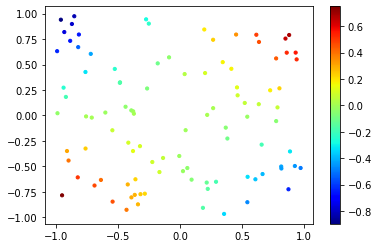

In [22]:
twod_scatter_plot_colored_value(X, yregress)

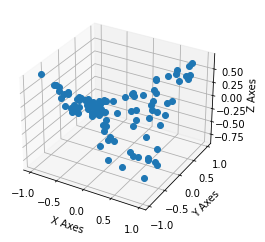

In [23]:
## another way to plot, less legible in my opinion
fig = plt.figure()
ax = plt.axes(projection="3d")
#Labeling
ax.set_xlabel('X Axes')
ax.set_ylabel('Y Axes')
ax.set_zlabel('Z Axes')
ax.plot3D(X[:,0], X[:,1], yregress, ls='', marker='o')
plt.show()

## Question 2.1 : code your regressor !

define a class `classLinearRegressorFullBatch`  that will perform regression, in a similar fashion as `classLinearClassifierFullBatch` did perform a (binary) classification.
There should be only 2,3 or 4 lines at most to change.

Remember:
- the model and cost function are essentially (or exactly?) the same
- the prediction now takes in values in $\mathbb{R}$
- the score is now defined not as the number of correctly classified points, but as the Mean Squared Error. In other terms, it's essentially equal to the Loss.

In [24]:
def plot_prediction_regress(reg, X, y, featureMap=None):  
    if featureMap == None:
        featureMap = defaultFeatureMap
    h = 0.02 ## grid mesh size
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1 
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig = plt.figure()
    Z = reg.predict(featureMap(np.c_[xx.ravel(), yy.ravel()])) ## prediction value by zone
    Z = Z.reshape(xx.shape)
    plt.contourf(xx,yy,Z)
    plt.colorbar()
    twod_scatter_plot_colored_value(X, y)


In [26]:
#
#the other kind of plot 
def plot_prediction_regress_2(reg, X, y, featureMap=None):  
    if featureMap == None:
        featureMap = defaultFeatureMap
    h = 0.02 ## grid mesh size
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1 
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig = plt.figure()
    ax = plt.axes(projection="3d")
    Z = reg.predict(featureMap(np.c_[xx.ravel(), yy.ravel()])) ## prediction value by zone
    Z = Z.reshape(xx.shape)
    plt.title('score : ' + str(reg.score(featureMap(X),y)))  
    ax.plot3D(xx.flatten(), yy.flatten(), Z.flatten(),marker='o', ls='',color="green")
    ax.scatter(X[:, 0], X[:, 1], y, c=y, s = 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()

In [27]:
class classLinearRegressorFullBatch():

    def __init__(self, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        self.eta = eta
        self.maxIter = maxIter
        self.seed = seed
        self.w = None # at the start, it's undefined
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((D))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y):
        ## the full-batch perceptron in its cleanest form
        ## or really we should call it LinearClassifier with least squares loss, rather than Perceptron
        
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) # exgtended vector, with 1's as first component
        D = X.shape[1]        
        w0 = self.initializeWeights(D)       
        wparameters = w0.copy()  # deep copy
        assert(y.shape[0]==N)

        ## the algo itself ##
        for epoch in range(self.maxIter):
            tempo = (X@wparameters -y) ## array of shape (N,D)
            wparameters -= self.eta*(1./N)*(tempo @ X)
            Loss = (tempo**2).sum()
            if epoch % (self.maxIter//10) ==0 and self.verbose :
                print("epoch ",epoch ,"out of ",self.maxIter,", Loss:", Loss)      
        self.w = wparameters
        return wparameters
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) 
        ypredicted = np.dot(X,self.w) ## np.sign() is NOT PRESENT here !
        return ypredicted
    
    def score(self, X, y):
        ypred = self.predict(X)
        difference = (ypred-y)
        diffsquared = (np.abs(difference)**2).sum()  ## DIFFERENCE HERE  !
        rateOfCorrectClassif = 1 - diffsquared*1.0/X.shape[0]
        return rateOfCorrectClassif
        
        

## Now, run it

In [28]:
reg1 = classLinearRegressorFullBatch(eta=0.01, seed=42, maxIter=3000) # order of parameters does not matter
reg1.fit(X,yregress)
reg1.score(X,yregress)

epoch  0 out of  3000 , Loss: 14.896865771928072
epoch  300 out of  3000 , Loss: 12.173684570601488
epoch  600 out of  3000 , Loss: 11.881838615566542
epoch  900 out of  3000 , Loss: 11.840646430802593
epoch  1200 out of  3000 , Loss: 11.834746432539504
epoch  1500 out of  3000 , Loss: 11.83389507273835
epoch  1800 out of  3000 , Loss: 11.833771540044504
epoch  2100 out of  3000 , Loss: 11.833753541062686
epoch  2400 out of  3000 , Loss: 11.833750910524016
epoch  2700 out of  3000 , Loss: 11.833750525204858


0.8816624953132965

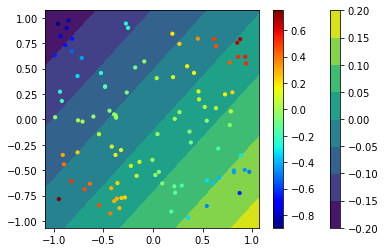

In [29]:
plot_prediction_regress(reg1, X, yregress)

## Question 2.2: does it work well ? why ?

## Answer: 

No, it doesn't. We need to use the Kernel (or rather feature-space) trick.


- As before, use a trick to make your LINEAR algorithm become really good.
- plot the predictions and data using the function `plot_prediction_regress()`
- are you happy now ? 

In [30]:
reg2 = classLinearRegressorFullBatch(eta=0.01, seed=42, maxIter=30000) # order of parameters does not matter
Xf = featureMap(X)
reg2.fit(Xf,yregress)
reg2.score(Xf,yregress)

epoch  0 out of  30000 , Loss: 12.755685089232607
epoch  3000 out of  30000 , Loss: 0.018379147027456508
epoch  6000 out of  30000 , Loss: 0.00948854200585535
epoch  9000 out of  30000 , Loss: 0.00947073653119832
epoch  12000 out of  30000 , Loss: 0.009470462856388933
epoch  15000 out of  30000 , Loss: 0.009470455945655388
epoch  18000 out of  30000 , Loss: 0.009470455766581665
epoch  21000 out of  30000 , Loss: 0.009470455761931543
epoch  24000 out of  30000 , Loss: 0.009470455761810726
epoch  27000 out of  30000 , Loss: 0.00947045576180759


0.9999052954423819

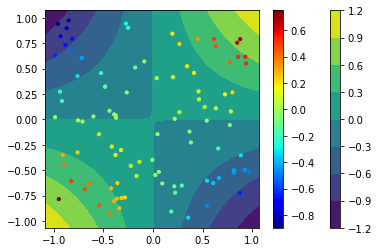

In [31]:
plot_prediction_regress(reg2, X, yregress, featureMap)

## Answer: now we are happy, indeed.

## Quesiton 2.3 Compute also the test error and plot the prediction on the test data

(in this case it's not very instructive, but it's a good habit to take)

In [32]:
X_test.shape

(1000, 2)

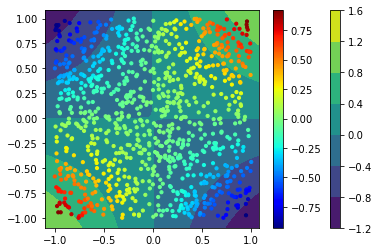

In [33]:
plot_prediction_regress(reg2, X_test, yregress_test, featureMap)

### If you run the code below and want to play again with your code above this point, you should re-load the part 1&2 data !


In [34]:
X, yregress, yclassif = TP3_helper_function_dont_look.getData(42)
X_test, yregress_test, yclassif_test = TP3_helper_function_dont_look.getData(41, 1000)

## Question 2.4:

build the *learning curve* of the problem.

You may choose an exponentially growing number of training examples, such as `Ntrains = [10,30,100,300,1000, 3000, 10000]`, and a large number of test examples, for the sake of having a precise estimation of the test error. You should probably use log-log or semilog- plots.
    

In [38]:
featureMapHere = featureMap
reg2 = classLinearRegressorFullBatch(eta=0.01, seed=41, maxIter=30000, verbose=False) # order of parameters does not matter

model = reg2
score_train =[]
score_test  =[]
Ntrains = [2**k for k in range(10)]
X_test, yregress_test, yclassif_test = TP3_helper_function_dont_look.getData(41, 10000)
Xf_test = featureMapHere(X_test)
for Ntrain in Ntrains:
    X, yregress, yclassif = TP3_helper_function_dont_look.getData(42, Ntrain)
    Xf = featureMapHere(X)
    model.fit(Xf,yregress)
    score_train.append(model.score(Xf,yregress))
    score_test .append(model.score(Xf_test,yregress_test))
score_train = np.array(score_train)
score_test = np.array(score_test)


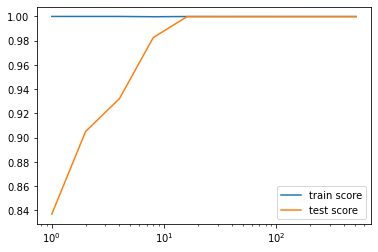

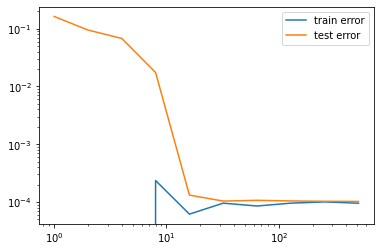

In [39]:
plt.semilogx(Ntrains, score_train, label="train score")
plt.plot(Ntrains, score_test, label="test score")
plt.legend()
plt.figure()
plt.loglog(Ntrains, 1-score_train, label="train error")
plt.plot(Ntrains, 1-score_test, label="test error")
plt.legend()

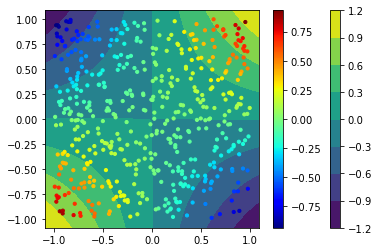

In [40]:
plot_prediction_regress(reg2, X, yregress, featureMap)

# Part 3 : the moon data set

The so-called moons data set can be generated with sklearn:

In [41]:
from sklearn.datasets import make_moons
data = make_moons(noise = 0.1, random_state=1, n_samples=400)

In [42]:
data

(array([[ 2.04733811,  0.43575746],
        [-0.35419196,  0.9948636 ],
        [ 1.31605366, -0.37611791],
        [ 1.37422305, -0.35665477],
        [-0.86346822,  0.27359801],
        [ 1.67661327, -0.30798713],
        [-1.02201434,  0.06953774],
        [ 0.85464424, -0.50567222],
        [ 1.07395801,  0.44167181],
        [ 0.69109171, -0.5473944 ],
        [-0.94961863,  0.49523406],
        [ 1.77565052,  0.14563444],
        [-0.98116417,  0.07751198],
        [ 1.25710495, -0.43403325],
        [ 1.41192797, -0.22433074],
        [-0.00319327,  0.12672869],
        [ 1.8242945 ,  0.14424518],
        [ 1.14604746,  0.08897025],
        [ 0.44276245,  0.95446404],
        [ 0.19744232,  0.24314332],
        [-0.22206377,  0.98383235],
        [ 0.12037794, -0.02728439],
        [ 2.03779945,  0.09969666],
        [ 0.13674744,  0.22213811],
        [ 1.1102022 ,  0.23735935],
        [ 0.16178656,  0.99682086],
        [ 2.01634568,  0.26205944],
        [-0.03616695,  0.392

# Question 3.1: solve the task

- On your own, identify which kind of task is at hand:
    - what kind of data is it ?
    - is it supervised, unsupervised ? Which sub-class of ML is it ?
    - is the data in the form you need (label values taking the expected kind of values for instance) ? Is it well standardized ?
- Using a simple (linear) model that you already have from previous work, try to solve the task.
- are you satisfied with the result ? What can we do ? 
- you may need to use a slightly more complicated feature map than before

# Answers to 3.1: solve the task

- On your own, identify which kind of task is at hand:
    - what kind of data is it ? **there is D=2 data, with binary labels**
    - is it supervised, unsupervised ? Which sub-class of ML is it ? **Supervised, because we have $y$**.
    - is the data in the form you need (label values taking the expected kind of values for instance) ? Is it well standardized ?
    **It is *not* in the correct format.** $y\in \{0,1\}$ **will NOT work with our classification algorithm. We did not code it in a sufficiently flexible way !**
    
- Using a simple (linear) model that you already have from previous work, try to solve the task. **Ok we just have to re-use the good old** `classLinearClassifierFullBatch` **class**
- are you satisfied with the result ? What can we do ? **Not satisfied: a linear model is not enough. We need more features !**
- you may need to use a slightly more complicated feature map than before **Indeed, a 2nd order polynomial feature map is not enough. We need to go to 3rd order**

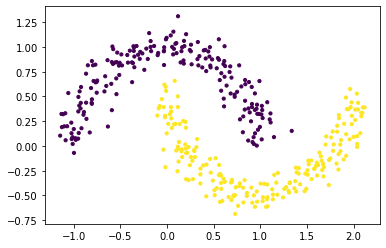

In [43]:
X, yclassif = data
yclassif = yclassif *2 -1
plt.figure()
plt.scatter(X[:,0],X[:,1], c = yclassif, s = 10)

In [44]:
clf3 = classLinearClassifierFullBatch(eta=0.01, seed=41, maxIter=3000) # order of parameters does not matter
Xf = featureMap(X)
clf3.fit(Xf,yclassif)
clf3.score(Xf,yclassif)

epoch  0 out of  3000 , Loss: -109.65067771554386
epoch  300 out of  3000 , Loss: -0.763779001337032
epoch  600 out of  3000 , Loss: -0.49178702786197687
epoch  900 out of  3000 , Loss: -0.2338385625652667
epoch  1200 out of  3000 , Loss: 0.0038560105986043124
epoch  1500 out of  3000 , Loss: -0.03838395222392341
epoch  1800 out of  3000 , Loss: 0.2601610132366111
epoch  2100 out of  3000 , Loss: -0.04387579937350651
epoch  2400 out of  3000 , Loss: -0.03139036475425114
epoch  2700 out of  3000 , Loss: -0.001338425672818508


0.865

No handles with labels found to put in legend.


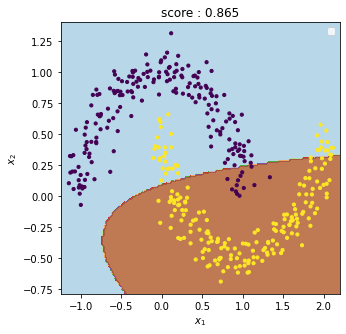

In [45]:
plot_boundary(clf3, X, yclassif, featureMap)

In [32]:
def featureMap2(X):
    return np.array([ X[:,0], X[:,1], X[:,0]**2, X[:,0]*X[:,1], X[:,1]**2, X[:,0]**3, X[:,1]**3]).T

In [33]:
clf3 = classLinearClassifierFullBatch(eta=0.025, seed=41, maxIter=90000) # order of parameters does not matter
Xf = featureMap2(X)
clf3.fit(Xf,yclassif)
clf3.score(Xf,yclassif)

epoch  0 out of  90000 , Loss: -933.926681712762
epoch  9000 out of  90000 , Loss: -0.04858649512907501
epoch  18000 out of  90000 , Loss: 0.10699887641535286
epoch  27000 out of  90000 , Loss: 0.09119428280962552
epoch  36000 out of  90000 , Loss: 0.09333201092030999
epoch  45000 out of  90000 , Loss: 0.10838141118392758
epoch  54000 out of  90000 , Loss: 0.10769232667742434
epoch  63000 out of  90000 , Loss: 0.10689582419202695
epoch  72000 out of  90000 , Loss: 0.094617994109986
epoch  81000 out of  90000 , Loss: 0.1077405091376526


0.9679

No handles with labels found to put in legend.


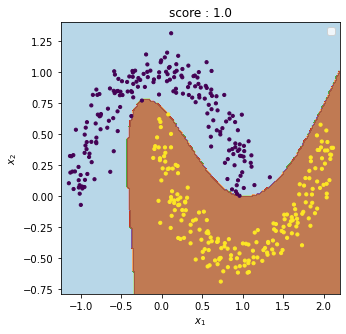

In [48]:
plot_boundary(clf3, X, yclassif, featureMap2)

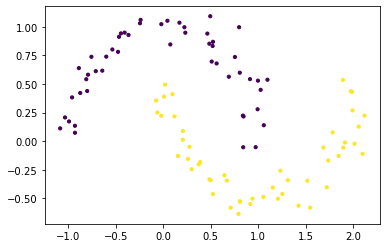

In [49]:
X_test, y_test = make_moons(noise = 0.1, random_state=321, n_samples=100)
plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c = y_test, s = 10)
y_test = y_test *2 -1

No handles with labels found to put in legend.


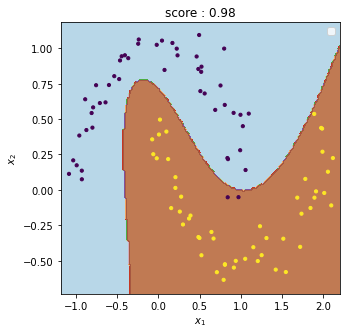

In [50]:
plot_boundary(clf3, X_test, y_test, featureMap2)